<a href="https://colab.research.google.com/github/Sassy1921/appliances_energy_prediction/blob/main/appliances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sqrt
from sklearn.model_selection import train_test_split
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dropout,BatchNormalization,Bidirectional
from keras.layers import Dense
from matplotlib import pyplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/data/energydata_complete.csv")
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [4]:
# convert series to supervised learning
def series_to_supervised(df_columns,dataset, n_in=1, n_out=1, dropnan=True):
    num_vars = 1 if type(dataset) is list else dataset.shape[1]
    dataframe = DataFrame(dataset)
    cols, names = list(), list()
    
    # input sequence (t-n, ....t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [f"{col}(t-{i})" for col in df_columns]
    # forecast sequence (t, t+1 .... t+n)
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [f"{col}(t)" for col in df_columns]
        else:
            names += [f"{col}(t+{i})" for col in df_columns]
    
    # put it all together 
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
col_time=["date"]

col_target = ["Appliances"]

feature=["RH_out","RH_8","RH_1","T3","RH_3","T2","Press_mm_hg","RH_2","RH_7","T8","RH_6","RH_4","RH_5","T_out","RH_9",
             "T4","T7","Tdewpoint","Windspeed","T1","T5"]

In [6]:
data1 = data[col_target + col_time + feature]

In [7]:
test = data1.tail(30)
test

,Appliances,date,RH_out,RH_8,RH_1,T3,RH_3,T2,Press_mm_hg,RH_2,...,RH_4,RH_5,T_out,RH_9,T4,T7,Tdewpoint,Windspeed,T1,T5
19705,280,2016-05-27 13:10:00,59.833333,49.090000,48.363333,28.496667,41.900000,26.528571,756.05,40.595714,...,45.066667,52.900000,21.250000,46.500000,24.500000,23.890000,13.100000,1.166667,25.033333,22.760000
19706,240,2016-05-27 13:20:00,59.666667,49.163333,48.156667,28.290000,41.966667,26.600000,756.00,40.940000,...,45.333333,53.000000,21.400000,46.500000,24.500000,23.905714,13.200000,1.333333,25.166667,22.790000
19707,250,2016-05-27 13:30:00,59.500000,49.290000,47.930000,28.200000,42.090000,26.600000,755.95,41.012857,...,45.566667,53.060000,21.550000,46.522500,24.533333,23.934000,13.300000,1.500000,25.323333,22.790000
19708,220,2016-05-27 13:40:00,59.333333,49.290000,47.656667,28.200000,42.030000,26.600000,755.90,41.036000,...,45.760000,53.200000,21.700000,46.530000,24.600000,23.890000,13.400000,1.666667,25.390000,22.790000
19709,230,2016-05-27 13:50:00,59.166667,49.326667,47.133333,28.200000,41.796667,26.600000,755.85,41.000000,...,45.790000,53.260000,21.850000,46.530000,24.600000,23.890000,13.500000,1.833333,25.500000,22.856667
19710,190,2016-05-27 14:00:00,59.000000,49.326667,47.060000,28.200000,41.530000,26.540000,755.80,41.000000,...,45.863333,53.200000,22.000000,46.530000,24.600000,23.905714,13.600000,2.000000,25.500000,22.890000
19711,160,2016-05-27 14:10:00,59.000000,49.345000,46.990000,28.200000,41.590000,26.512500,755.80,41.203750,...,46.030000,53.200000,21.966667,46.530000,24.633333,23.934000,13.550000,2.000000,25.600000,22.890000
19712,80,2016-05-27 14:20:00,59.000000,49.326667,46.730000,28.426667,41.430000,26.437143,755.80,41.384286,...,46.090000,53.090000,21.933333,46.590000,24.700000,23.968571,13.500000,2.000000,25.600000,22.890000
19713,60,2016-05-27 14:30:00,59.000000,49.326667,46.633333,28.566667,41.156667,26.370000,755.80,41.378000,...,45.966667,53.030000,21.900000,46.626667,24.700000,24.000000,13.450000,2.000000,25.566667,22.890000
19714,60,2016-05-27 14:40:00,59.000000,49.163333,46.360000,28.566667,40.663333,26.318571,755.80,41.264286,...,45.826667,52.966667,21.866667,46.700000,24.700000,24.000000,13.400000,2.000000,25.500000,22.890000


In [8]:
data1["date"]=pd.to_datetime(data1["date"])
data1 = data1.set_index(['date'], drop=True)
data1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Appliances,RH_out,RH_8,RH_1,T3,RH_3,T2,Press_mm_hg,RH_2,RH_7,...,RH_4,RH_5,T_out,RH_9,T4,T7,Tdewpoint,Windspeed,T1,T5
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,92.0,48.900000,47.596667,19.79,44.730000,19.2,733.5,44.790000,41.626667,...,45.566667,55.20,6.600000,45.53,19.000000,17.200000,5.3,7.000000,19.89,17.166667
2016-01-11 17:10:00,60,92.0,48.863333,46.693333,19.79,44.790000,19.2,733.6,44.722500,41.560000,...,45.992500,55.20,6.483333,45.56,19.000000,17.200000,5.2,6.666667,19.89,17.166667
2016-01-11 17:20:00,50,92.0,48.730000,46.300000,19.79,44.933333,19.2,733.7,44.626667,41.433333,...,45.890000,55.09,6.366667,45.50,18.926667,17.200000,5.1,6.333333,19.89,17.166667
2016-01-11 17:30:00,50,92.0,48.590000,46.066667,19.79,45.000000,19.2,733.8,44.590000,41.290000,...,45.723333,55.09,6.250000,45.40,18.890000,17.133333,5.0,6.000000,19.89,17.166667
2016-01-11 17:40:00,60,92.0,48.590000,46.333333,19.79,45.000000,19.2,733.9,44.530000,41.230000,...,45.530000,55.09,6.133333,45.40,18.890000,17.200000,4.9,5.666667,19.89,17.200000


In [9]:
test["date"]=pd.to_datetime(test["date"])
test = test.set_index(['date'], drop=True)
test.head()

,Appliances,RH_out,RH_8,RH_1,T3,RH_3,T2,Press_mm_hg,RH_2,RH_7,...,RH_4,RH_5,T_out,RH_9,T4,T7,Tdewpoint,Windspeed,T1,T5
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 13:10:00,280,59.833333,49.090000,48.363333,28.496667,41.900000,26.528571,756.05,40.595714,43.5,...,45.066667,52.90,21.25,46.5000,24.500000,23.890000,13.1,1.166667,25.033333,22.760000
2016-05-27 13:20:00,240,59.666667,49.163333,48.156667,28.290000,41.966667,26.600000,756.00,40.940000,43.5,...,45.333333,53.00,21.40,46.5000,24.500000,23.905714,13.2,1.333333,25.166667,22.790000
2016-05-27 13:30:00,250,59.500000,49.290000,47.930000,28.200000,42.090000,26.600000,755.95,41.012857,43.5,...,45.566667,53.06,21.55,46.5225,24.533333,23.934000,13.3,1.500000,25.323333,22.790000
2016-05-27 13:40:00,220,59.333333,49.290000,47.656667,28.200000,42.030000,26.600000,755.90,41.036000,43.5,...,45.760000,53.20,21.70,46.5300,24.600000,23.890000,13.4,1.666667,25.390000,22.790000
2016-05-27 13:50:00,230,59.166667,49.326667,47.133333,28.200000,41.796667,26.600000,755.85,41.000000,43.4,...,45.790000,53.26,21.85,46.5300,24.600000,23.890000,13.5,1.833333,25.500000,22.856667


In [10]:
values=data1.values
values.shape

(19735, 22)

In [11]:
valuestest = test.values
valuestest

array([[280.        ,  59.83333333,  49.09      ,  48.36333333,
         28.49666667,  41.9       ,  26.52857143, 756.05      ,
         40.59571429,  43.5       ,  23.79      ,   1.        ,
         45.06666667,  52.9       ,  21.25      ,  46.5       ,
         24.5       ,  23.89      ,  13.1       ,   1.16666667,
         25.03333333,  22.76      ],
       [240.        ,  59.66666667,  49.16333333,  48.15666667,
         28.29      ,  41.96666667,  26.6       , 756.        ,
         40.94      ,  43.5       ,  23.79      ,   1.        ,
         45.33333333,  53.        ,  21.4       ,  46.5       ,
         24.5       ,  23.90571429,  13.2       ,   1.33333333,
         25.16666667,  22.79      ],
       [250.        ,  59.5       ,  49.29      ,  47.93      ,
         28.2       ,  42.09      ,  26.6       , 755.95      ,
         41.01285714,  43.5       ,  23.89      ,   1.        ,
         45.56666667,  53.06      ,  21.55      ,  46.5225    ,
         24.53333333,  23.934 

In [12]:
data1

,Appliances,RH_out,RH_8,RH_1,T3,RH_3,T2,Press_mm_hg,RH_2,RH_7,...,RH_4,RH_5,T_out,RH_9,T4,T7,Tdewpoint,Windspeed,T1,T5
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,92.000000,48.900000,47.596667,19.790000,44.730000,19.200000,733.5,44.790000,41.626667,...,45.566667,55.200000,6.600000,45.5300,19.000000,17.200000,5.300000,7.000000,19.890000,17.166667
2016-01-11 17:10:00,60,92.000000,48.863333,46.693333,19.790000,44.790000,19.200000,733.6,44.722500,41.560000,...,45.992500,55.200000,6.483333,45.5600,19.000000,17.200000,5.200000,6.666667,19.890000,17.166667
2016-01-11 17:20:00,50,92.000000,48.730000,46.300000,19.790000,44.933333,19.200000,733.7,44.626667,41.433333,...,45.890000,55.090000,6.366667,45.5000,18.926667,17.200000,5.100000,6.333333,19.890000,17.166667
2016-01-11 17:30:00,50,92.000000,48.590000,46.066667,19.790000,45.000000,19.200000,733.8,44.590000,41.290000,...,45.723333,55.090000,6.250000,45.4000,18.890000,17.133333,5.000000,6.000000,19.890000,17.166667
2016-01-11 17:40:00,60,92.000000,48.590000,46.333333,19.790000,45.000000,19.200000,733.9,44.530000,41.230000,...,45.530000,55.090000,6.133333,45.4000,18.890000,17.200000,4.900000,5.666667,19.890000,17.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,55.666667,50.074000,46.560000,27.200000,41.163333,25.890000,755.2,42.025714,44.500000,...,45.590000,52.400000,22.733333,46.7900,24.700000,24.500000,13.333333,3.333333,25.566667,23.200000
2016-05-27 17:30:00,90,56.000000,49.790000,46.500000,27.133333,41.223333,25.754000,755.2,42.080000,44.414286,...,45.590000,52.326667,22.600000,46.7900,24.700000,24.557143,13.300000,3.500000,25.500000,23.230000
2016-05-27 17:40:00,270,56.333333,49.660000,46.596667,27.050000,41.690000,25.628571,755.2,42.768571,44.400000,...,45.730000,52.266667,22.466667,46.7900,24.700000,24.540000,13.266667,3.666667,25.500000,23.230000


In [13]:
reframed = series_to_supervised(data1.columns,values, 1, 1)
new_values=reframed.iloc[:,:23].values

In [14]:
reframed1 = series_to_supervised(test.columns,valuestest,1,1)
new_values_test = reframed1.iloc[:,:23].values
new_values_test

array([[280.        ,  59.83333333,  49.09      ,  48.36333333,
         28.49666667,  41.9       ,  26.52857143, 756.05      ,
         40.59571429,  43.5       ,  23.79      ,   1.        ,
         45.06666667,  52.9       ,  21.25      ,  46.5       ,
         24.5       ,  23.89      ,  13.1       ,   1.16666667,
         25.03333333,  22.76      , 240.        ],
       [240.        ,  59.66666667,  49.16333333,  48.15666667,
         28.29      ,  41.96666667,  26.6       , 756.        ,
         40.94      ,  43.5       ,  23.79      ,   1.        ,
         45.33333333,  53.        ,  21.4       ,  46.5       ,
         24.5       ,  23.90571429,  13.2       ,   1.33333333,
         25.16666667,  22.79      , 250.        ],
       [250.        ,  59.5       ,  49.29      ,  47.93      ,
         28.2       ,  42.09      ,  26.6       , 755.95      ,
         41.01285714,  43.5       ,  23.89      ,   1.        ,
         45.56666667,  53.06      ,  21.55      ,  46.5225    ,
  

In [15]:
X = new_values[:,:22]
Y = new_values[:,22]

In [16]:
Xtest = new_values_test[:,:22]
Ytest = new_values_test[:,22]

In [17]:
reframed1.head()

,Appliances(t-1),RH_out(t-1),RH_8(t-1),RH_1(t-1),T3(t-1),RH_3(t-1),T2(t-1),Press_mm_hg(t-1),RH_2(t-1),RH_7(t-1),...,RH_4(t),RH_5(t),T_out(t),RH_9(t),T4(t),T7(t),Tdewpoint(t),Windspeed(t),T1(t),T5(t)
1,280.0,59.833333,49.090000,48.363333,28.496667,41.900000,26.528571,756.05,40.595714,43.5,...,45.333333,53.00,21.40,46.5000,24.500000,23.905714,13.2,1.333333,25.166667,22.790000
2,240.0,59.666667,49.163333,48.156667,28.290000,41.966667,26.600000,756.00,40.940000,43.5,...,45.566667,53.06,21.55,46.5225,24.533333,23.934000,13.3,1.500000,25.323333,22.790000
3,250.0,59.500000,49.290000,47.930000,28.200000,42.090000,26.600000,755.95,41.012857,43.5,...,45.760000,53.20,21.70,46.5300,24.600000,23.890000,13.4,1.666667,25.390000,22.790000
4,220.0,59.333333,49.290000,47.656667,28.200000,42.030000,26.600000,755.90,41.036000,43.5,...,45.790000,53.26,21.85,46.5300,24.600000,23.890000,13.5,1.833333,25.500000,22.856667
5,230.0,59.166667,49.326667,47.133333,28.200000,41.796667,26.600000,755.85,41.000000,43.4,...,45.863333,53.20,22.00,46.5300,24.600000,23.905714,13.6,2.000000,25.500000,22.890000


In [18]:
reframed.head()

,Appliances(t-1),RH_out(t-1),RH_8(t-1),RH_1(t-1),T3(t-1),RH_3(t-1),T2(t-1),Press_mm_hg(t-1),RH_2(t-1),RH_7(t-1),...,RH_4(t),RH_5(t),T_out(t),RH_9(t),T4(t),T7(t),Tdewpoint(t),Windspeed(t),T1(t),T5(t)
1,60.0,92.0,48.900000,47.596667,19.79,44.730000,19.2,733.5,44.790000,41.626667,...,45.992500,55.20,6.483333,45.56,19.000000,17.200000,5.2,6.666667,19.89,17.166667
2,60.0,92.0,48.863333,46.693333,19.79,44.790000,19.2,733.6,44.722500,41.560000,...,45.890000,55.09,6.366667,45.50,18.926667,17.200000,5.1,6.333333,19.89,17.166667
3,50.0,92.0,48.730000,46.300000,19.79,44.933333,19.2,733.7,44.626667,41.433333,...,45.723333,55.09,6.250000,45.40,18.890000,17.133333,5.0,6.000000,19.89,17.166667
4,50.0,92.0,48.590000,46.066667,19.79,45.000000,19.2,733.8,44.590000,41.290000,...,45.530000,55.09,6.133333,45.40,18.890000,17.200000,4.9,5.666667,19.89,17.200000
5,60.0,92.0,48.590000,46.333333,19.79,45.000000,19.2,733.9,44.530000,41.230000,...,45.730000,55.03,6.016667,45.29,18.890000,17.133333,4.8,5.333333,19.89,17.133333


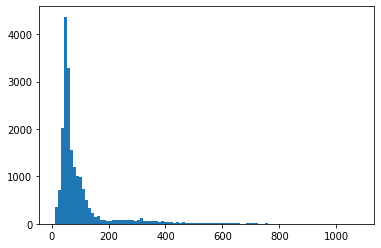

In [19]:
plt.hist(Y,bins=100)
plt.show()

In [20]:
X.shape

(19734, 22)

In [21]:
def pad_values(X,Y,seq_len):
  n_test=X.shape[0]
  pad=(n_test//seq_len+1)*seq_len-n_test
  new_x_shape=(-1,seq_len,22)
  new_y_shape=(-1,seq_len,1)
  return np.concatenate((X,np.zeros((pad,22)))).reshape(new_x_shape),np.concatenate((Y,np.zeros((pad)))).reshape(new_y_shape)


In [22]:
seq_len=30
pad_X,pad_Y=pad_values(X,Y,seq_len)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(pad_X, pad_Y, test_size=0.25)



In [23]:
seq_len=30
pad_Xtest,pad_Ytest=pad_values(Xtest,Ytest,seq_len)

In [24]:
model = Sequential()

model.add(Bidirectional(LSTM(300,return_sequences=True, input_shape=(X_Train.shape[1], X_Train.shape[2]))))
model.add(Dropout(0.3))
model.add(LSTM(200, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')


# fit
history = model.fit(X_Train, Y_Train, epochs=2000, batch_size=128, validation_data=(X_Test, Y_Test), verbose=2, shuffle=True)

Epoch 1/2000
4/4 - 14s - loss: 19939.0098 - val_loss: 17685.9902 - 14s/epoch - 3s/step
Epoch 2/2000
4/4 - 0s - loss: 18473.7559 - val_loss: 17719.8887 - 169ms/epoch - 42ms/step
Epoch 3/2000
4/4 - 0s - loss: 17164.8730 - val_loss: 17908.5293 - 154ms/epoch - 38ms/step
Epoch 4/2000
4/4 - 0s - loss: 15898.9766 - val_loss: 18077.2930 - 127ms/epoch - 32ms/step
Epoch 5/2000
4/4 - 0s - loss: 14702.9443 - val_loss: 17973.3750 - 119ms/epoch - 30ms/step
Epoch 6/2000
4/4 - 0s - loss: 13803.2783 - val_loss: 17933.2090 - 121ms/epoch - 30ms/step
Epoch 7/2000
4/4 - 0s - loss: 12847.2803 - val_loss: 17717.6523 - 119ms/epoch - 30ms/step
Epoch 8/2000
4/4 - 0s - loss: 12117.9814 - val_loss: 17591.3359 - 118ms/epoch - 30ms/step
Epoch 9/2000
4/4 - 0s - loss: 11533.8975 - val_loss: 17436.9434 - 127ms/epoch - 32ms/step
Epoch 10/2000
4/4 - 0s - loss: 11135.2520 - val_loss: 17369.0840 - 121ms/epoch - 30ms/step
Epoch 11/2000
4/4 - 0s - loss: 10845.0703 - val_loss: 17230.5508 - 125ms/epoch - 31ms/step
Epoch 12/20

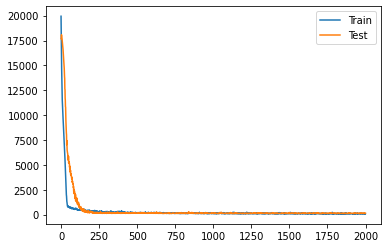

In [25]:
pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

In [26]:
y_pred_test_lstm = model.predict(X_Test)


6/6 [==============================] - 1s 11ms/step


In [27]:
y_pred = model.predict(pad_Xtest)

1/1 [==============================] - 0s 23ms/step


In [28]:
pad_Ytest

array([[[240.],
        [250.],
        [220.],
        [230.],
        [190.],
        [160.],
        [ 80.],
        [ 60.],
        [ 60.],
        [ 60.],
        [ 60.],
        [ 70.],
        [ 80.],
        [ 80.],
        [ 70.],
        [100.],
        [100.],
        [ 90.],
        [100.],
        [220.],
        [180.],
        [120.],
        [110.],
        [ 90.],
        [100.],
        [ 90.],
        [270.],
        [420.],
        [430.],
        [  0.]]])

In [29]:
y_pred

array([[[229.8771  ],
        [240.34538 ],
        [214.90771 ],
        [213.5923  ],
        [181.68388 ],
        [146.55301 ],
        [ 77.14809 ],
        [ 60.52019 ],
        [ 60.888073],
        [ 60.57854 ],
        [ 60.403896],
        [ 69.13759 ],
        [ 80.31554 ],
        [ 80.5145  ],
        [ 69.708435],
        [ 97.69033 ],
        [ 98.24376 ],
        [ 90.494316],
        [ 98.00985 ],
        [203.3936  ],
        [173.41728 ],
        [113.18649 ],
        [109.53731 ],
        [ 91.535286],
        [101.871216],
        [ 90.92621 ],
        [266.5092  ],
        [412.87674 ],
        [307.80026 ],
        [ 18.705332]]], dtype=float32)

In [30]:
y_pred_test_lstm[164]

array([[ 52.26059 ],
       [ 71.90769 ],
       [ 73.430046],
       [ 84.58769 ],
       [ 64.043076],
       [ 52.71903 ],
       [305.66034 ],
       [381.82083 ],
       [293.5484  ],
       [296.8045  ],
       [247.9322  ],
       [239.9116  ],
       [132.87123 ],
       [102.23027 ],
       [106.47174 ],
       [223.6925  ],
       [234.55151 ],
       [157.15654 ],
       [102.74152 ],
       [112.52797 ],
       [105.91407 ],
       [ 96.54451 ],
       [105.32777 ],
       [ 95.35164 ],
       [103.31308 ],
       [102.59783 ],
       [102.93556 ],
       [102.58121 ],
       [101.338806],
       [ 90.73919 ]], dtype=float32)

In [31]:
Y_Test[164]

array([[ 50.],
       [ 70.],
       [ 70.],
       [ 80.],
       [ 60.],
       [ 50.],
       [320.],
       [390.],
       [300.],
       [310.],
       [250.],
       [250.],
       [130.],
       [100.],
       [100.],
       [220.],
       [240.],
       [150.],
       [100.],
       [110.],
       [100.],
       [ 90.],
       [100.],
       [ 90.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.],
       [100.]])

In [32]:
import os.path
if os.path.isfile('energypredictionfinal.h5') is False:
    model.save('energypredictionfinal.h5')

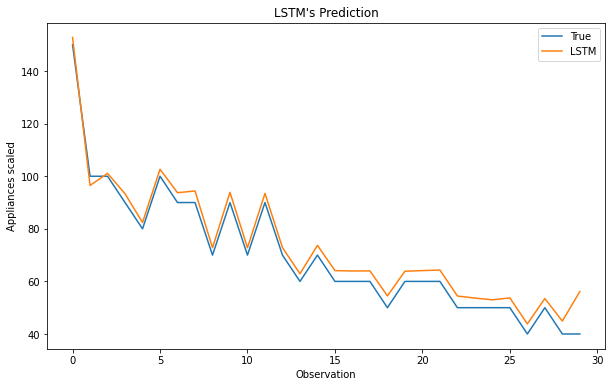

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(Y_Test[1], label='True')
plt.plot(y_pred_test_lstm[1], label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Appliances scaled')
plt.legend()
plt.show();